# Similarity search for motif mining

In this tutorial, we demonstrate how to utilize the similarity functionality to discover images with similar motifs from a collection of Reddit images. We employ the classic `SIFT` feature to identify images with a strikingly similar appearance (image-level pipeline).

Additionally, we extend the pipeline by incorporating an object detection model, `YOLO`, in combination with the SIFT feature. This enables us to identify objects within the images that exhibit a similar appearance (object-level similarity).

To illustrate the seamless integration of different vector stores, we leverage the power of multiple vector stores, namely `FAISS` and `QDRANT`, within evadb. This demonstrates the ease with which you can utilize diverse vector stores to construct indexes, enhancing your similarity search experience.

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/11-similarity-search-for-motif-mining.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/11-similarity-search-for-motif-mining.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/raw/master/tutorials/11-similarity-search-for-motif-mining.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table>

### Start EVA server

We are reusing the start server notebook for launching the EVA server.

In [1]:
%run 00-start-eva-server.ipynb
cursor = connect_to_server()

nohup eva_server > eva.log 2>&1 &


### Download reddit dataset

In [2]:

!wget -nc https://www.dropbox.com/scl/fo/fcj6ojmii0gw92zg3jb2s/h\?dl\=1\&rlkey\=j3kj1ox4yn5fhonw06v0pn7r9 -O reddit-images.zip
!unzip -o reddit-images.zip -d reddit-images

File 'reddit-images.zip' already there; not retrieving.


Archive:  reddit-images.zip
mapname:  conversion of  failed
 extracting: reddit-images/g348_d7jphyc.jpg  
 extracting: reddit-images/g348_d7jgzgf.png  
 extracting: reddit-images/g348_d7jhhs3.jpg  
 extracting: reddit-images/g348_d7ju7dq.png  
 extracting: reddit-images/g1074_d4n1lmn.png  
 extracting: reddit-images/g1074_d4n60oy.jpg  
 extracting: reddit-images/g1074_d4n6fgs.jpg  
 extracting: reddit-images/g1190_cln97xm.jpg  
 extracting: reddit-images/g1074_d4mxztt.png  
 extracting: reddit-images/g1190_cln9xzr.png  
 extracting: reddit-images/g1190_clna260.png  
 extracting: reddit-images/g1190_clna2x2.png  
 extracting: reddit-images/g1190_clna91w.png  
 extracting: reddit-images/g1190_clnad42.png  
 extracting: reddit-images/g1190_clnapoy.jpg  
 extracting: reddit-images/g1190_clnarjl.png  
 extracting: reddit-images/g1190_clnavnu.jpg  
 extracting: reddit-images/g1190_clnbalu.png  


 extracting: reddit-images/g1190_clnajd7.png  
 extracting: reddit-images/g1190_clnc4uy.png  
 extracting: reddit-images/g1190_clnce4b.jpg  
 extracting: reddit-images/g1190_clncot0.jpg  
 extracting: reddit-images/g1190_clndsnu.png  
 extracting: reddit-images/g1209_ct65pvl.jpg  
 extracting: reddit-images/g1209_ct66erw.jpg  
 extracting: reddit-images/g1209_ct67oqk.jpg  
 extracting: reddit-images/g1209_ct6bf1n.png  
 extracting: reddit-images/g1418_cj3o1h6.png  
 extracting: reddit-images/g1418_cj3qysz.jpg  
 extracting: reddit-images/g1209_ct6a0g5.png  
 extracting: reddit-images/g1418_cj3om3h.jpg  
 extracting: reddit-images/g1418_cj3r4gw.jpg  
 extracting: reddit-images/g1418_cj3z7jw.jpg  
 extracting: reddit-images/g1190_clnbf07.jpg  


### Load all images into evadb

In [3]:
cursor.execute("DROP TABLE IF EXISTS reddit_dataset;")
response = cursor.fetch_all()
cursor.execute("LOAD IMAGE 'reddit-images/*.jpg' INTO reddit_dataset;")
response = cursor.fetch_all()
print(response.as_df())
cursor.execute("LOAD IMAGE 'reddit-images/*.png' INTO reddit_dataset;")
response = cursor.fetch_all()
print(response.as_df())

                            0
0  Number of loaded IMAGE: 17


                            0
0  Number of loaded IMAGE: 17


### Register a SIFT FeatureExtractor 
It uses `kornia` library to extract sift features for each image

In [4]:
!pip install kornia --quiet

In [5]:
cursor.execute("""CREATE UDF IF NOT EXISTS SiftFeatureExtractor
                    IMPL  '../eva/udfs/sift_feature_extractor.py'""")
response = cursor.fetch_all()
response.as_df()

,0
0,UDF SiftFeatureExtractor successfully added to...


In [6]:
# Keep track of which image gets the most votes
from collections import Counter
vote = Counter()

## Image-level similarity search pipeline. 
This pipeline creates one vector per image. Next, we should breakdown steps how we build the index and search similar vectors using the index.

In [7]:
#1. Create index for the entire image
cursor.execute("""CREATE INDEX reddit_sift_image_index 
                    ON reddit_dataset (SiftFeatureExtractor(data)) 
                    USING FAISS""")
response = cursor.fetch_all()
print(response.as_df())

                                                   0
0  Index reddit_sift_image_index successfully add...


In [8]:
#2. Search similar vectors
cursor.execute("""SELECT name FROM reddit_dataset ORDER BY
                    Similarity(
                      SiftFeatureExtractor(Open('reddit-images/g1190_clna260.png')),
                      SiftFeatureExtractor(data)
                    )
                    LIMIT 5""")
response = cursor.fetch_all()
response.as_df()

,reddit_dataset.name
0,reddit-images/g1190_clna260.png
1,reddit-images/g1190_clndsnu.png
2,reddit-images/g1190_clna91w.png
3,reddit-images/g1190_clnc4uy.png
4,reddit-images/g1190_cln97xm.jpg


In [9]:
#3. Update votes
res_df = response.as_df()
for i in range(len(res_df)):
    vote[res_df["reddit_dataset.name"][i]] += 1
print(vote)

Counter({'reddit-images/g1190_clna260.png': 1, 'reddit-images/g1190_clndsnu.png': 1, 'reddit-images/g1190_clna91w.png': 1, 'reddit-images/g1190_clnc4uy.png': 1, 'reddit-images/g1190_cln97xm.jpg': 1})


## Object-level similarity search pipeline. 
This pipeline detects objects within images and generates vectors exclusively from the cropped objects. The index is then constructed using these vectors. To showcase the versatility of `evadb`, we leverage `Qdrant` vector store specifically for building this index. This demonstrates how seamlessly you can leverage different vector stores within evadb.

### 1. Extract all the object using `Yolo` from the images

In [10]:

cursor.execute("""
              CREATE MATERIALIZED VIEW reddit_object_dataset (name, data, bboxes,labels)
                AS SELECT name, data, bboxes, labels FROM reddit_dataset
                  JOIN LATERAL UNNEST(Yolo(data)) AS Obj(labels, bboxes, scores)""")
response = cursor.fetch_all()

### 2. Build an index on the feature vectors of the extracted objects

In [11]:
cursor.execute("""CREATE INDEX reddit_sift_object_index
                    ON reddit_object_dataset (SiftFeatureExtractor(Crop(data, bboxes)))
                    USING QDRANT""")
response = cursor.fetch_all()
response.as_df()

,0
0,Index reddit_sift_object_index successfully ad...


In [12]:
# Create a cropped images (We are actively working on features to allow
# us to not do this outside SQL)
cursor.execute("LOAD IMAGE 'reddit-images/g1190_clna260.png' INTO reddit_search_image_dataset")
response = cursor.fetch_all()
print(response.as_df())
cursor.execute("SELECT Yolo(data).bboxes FROM reddit_search_image_dataset")
response = cursor.fetch_all()
print(response.as_df())


import cv2
import pathlib

res_df = response.as_df()
bboxes = res_df["yolo.bboxes"][0]

img = cv2.imread("reddit-images/g1190_clna260.png")
pathlib.Path("reddit-images/search-object/").mkdir(parents=True, exist_ok=True)
for i, bbox in enumerate(bboxes):
    xmin, ymin, xmax, ymax = bbox
    xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
    cropped_img = img[ymin:ymax, xmin:xmax]
    cv2.imwrite(f"reddit-images/search-object/search-{i}.jpg", cropped_img)

                           0
0  Number of loaded IMAGE: 1


                                         yolo.bboxes
0  [[257.279296875, 256.9036865234375, 457.671325...


### 3. Retrieve using object-level similarity search

In [13]:
#4. 
import os

for path in os.listdir("reddit-images/search-object/"):
    path = "reddit-images/search-object/" + path
    cursor.execute(f"""SELECT name FROM reddit_object_dataset ORDER BY
                        Similarity(
                          SiftFeatureExtractor(Open('{path}')),
                          SiftFeatureExtractor(data)
                        )
                        LIMIT 1""")
    response = cursor.fetch_all()

    
    res_df = response.as_df()
    for i in range(len(res_df)):
        vote[res_df["reddit_object_dataset.name"][i]] += 0.5

    response.as_df()

# Combine the scores from image level and object level similarity to show similar images

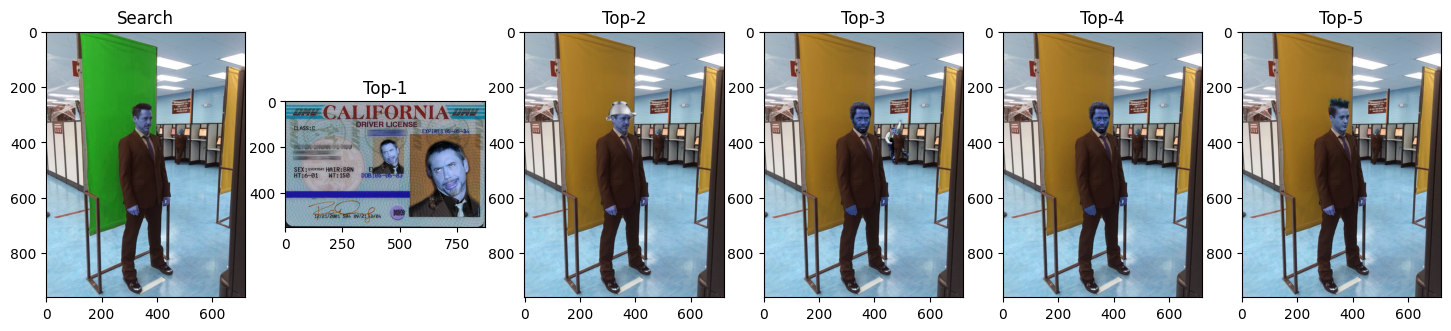

In [14]:
# !pip install matplotlib
import matplotlib.pyplot as plt

# Display top images
vote_list = list(reversed(sorted([(path, count) for path, count in vote.items()], key=lambda x: x[1])))
img_list = [path for path, _ in vote_list]

fig, ax = plt.subplots(nrows=1, ncols=6, figsize=[18,10])
ax[0].imshow(cv2.imread("reddit-images/g1190_clna260.png"))
ax[0].set_title("Search")

for i in range(5):
    axi = ax[i + 1]
    img = cv2.imread(img_list[i])
    axi.imshow(img)
    axi.set_title(f"Top-{i + 1}")

plt.show()